# Chord classifier


## Data preprocessing

In [11]:
conda install -c conda-forge ffmpeg libsndfile pandas numpy librosa matplotlib pytorch torchvision seaborn

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/admin/miniconda3/envs/chordenv

  added / updated specs:
    - ffmpeg
    - librosa
    - libsndfile
    - matplotlib
    - numpy
    - pandas
    - pytorch
    - seaborn
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.2.1              |       hd75f5a5_0         2.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following packages will be UPDATED:

  openssl                                  3.2.0-hd75f5a5_1 --> 3.2.1-hd75f5a5_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction:

In [12]:
%pip install spleeter "ray[tune]"

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip show ray

Name: ray
Version: 2.9.1
Summary: Ray provides a simple, universal API for building distributed applications.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages
Requires: aiosignal, click, filelock, frozenlist, jsonschema, msgpack, packaging, protobuf, pyyaml, requests
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ray

The purpose of preprocessing step, which is crucial for training the model, is to convert each chord represented as `wav` file into   spectrograms.


In [3]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

The scripts created for data preprocessing will be saved to code folder to ease their use in pipelines.

In [2]:
# TODO: replace to relative once hyperparameter tuning is done
data_dir = "/Users/admin/Projects/Chord Classifier/data"
preprocessed_train_data_dir = Path(os.path.join(data_dir, "preprocessed", "train"))
preprocessed_test_data_dir = Path(os.path.join(data_dir, "preprocessed", "test"))
preprocessed_train_data_dir.mkdir(parents=True, exist_ok=True)
preprocessed_test_data_dir.mkdir(parents=True, exist_ok=True)


### Data exploration


Show the number of chord recordings available for training and testing

In [5]:
train_data_dir = data_dir + "/Training"
test_data_dir = data_dir + "/Test"

def get_chord_counts(data_dir):
    chord_counts = {}

    for chord in os.listdir(data_dir):
        chord_path = os.path.join(data_dir, chord)
        if os.path.isdir(chord_path):
            chord_counts[chord] = len(os.listdir(chord_path))

    return chord_counts

In [6]:
print(f"Training data chord count {get_chord_counts(train_data_dir)}")
print(f"Testing data chord count {get_chord_counts(test_data_dir)}")

Training data chord count {'Am': 180, 'Bb': 180, 'Em': 180, 'G': 180, 'F': 180, 'Dm': 180, 'C': 180, 'Bdim': 180}
Testing data chord count {'Am': 40, 'Bb': 40, 'Em': 40, 'G': 40, 'F': 40, 'Dm': 40, 'C': 40, 'Bdim': 40}


Show the duration of sounds of chords. It ranges from 1.12 to 16.34 seconds with median about 5 seconds.

In [7]:
import librosa

durations = []

for chord in os.listdir(train_data_dir):
    chord_path = os.path.join(train_data_dir, chord)
    if os.path.isdir(chord_path):
        for file in os.listdir(chord_path):
            file_path = os.path.join(chord_path, file)
            y, sr = librosa.load(file_path, sr=None)
            durations.append(librosa.get_duration(y=y, sr=sr))

durations_df = pd.DataFrame(durations, columns=['duration'])
durations_df.describe()

duration
count  1440.000000
mean      5.631320
std       2.448665
min       1.123563
25%       4.381312
50%       5.048063
75%       6.000000
max      16.343855

A little trick to create an image from a spectrogram with matplotlib and then save it.

In [18]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

def create_spectrogram(audio_input, sr=None, save_path=None):
    # skip already existing sprectrogram
    if os.path.exists(save_path):
        print(f"Spectrogram  {save_path} already exists. Skipping.")
        return

    # Load the audio file if a path is provided, else use the provided audio data
    if isinstance(audio_input, str):
        y, sr = librosa.load(audio_input, sr=None)
    else:
        y = audio_input
        if sr is None:
            raise ValueError("Sampling rate must be provided with audio data")

    print(f"Creating spectrogram {save_path}")

    # Generate the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot and save the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format="jpg")
    plt.close()

    return S_dB


In [19]:
def convert_chords_to_spectrograms(source_dir, destination_dir):
    for chord in os.listdir(source_dir):
        chord_path = os.path.join(source_dir, chord)
        preprocessed_chord_path = os.path.join(destination_dir, chord)

        if not os.path.exists(preprocessed_chord_path):
            os.makedirs(preprocessed_chord_path)

        if os.path.isdir(chord_path):
            for file in os.listdir(chord_path):
                file_path = os.path.join(chord_path, file)

                y, sr = librosa.load(file_path, sr=None)

                # Calculate the number of samples per beat
                # 0.5 is the closest to average beat length so we will use this value for training
                beat_duration = 0.5
                samples_per_beat = int(beat_duration * sr)

                for i in range(0, len(y), samples_per_beat):
                    end_frame = i + samples_per_beat
                    if end_frame > len(y):
                        end_frame = len(y)  # Adjust the end frame for the last segment

                    segment = y[i:end_frame]
                    save_path = os.path.join(preprocessed_chord_path, os.path.splitext(file)[0] + "_" + str(i // samples_per_beat) + ".jpg")
                    # create spectrogram from a segment and save it to disk
                    create_spectrogram(segment, sr, save_path)


Convert train and test data. This will take a few minutes.


In [10]:
convert_chords_to_spectrograms(train_data_dir, preprocessed_train_data_dir)
convert_chords_to_spectrograms(test_data_dir, preprocessed_test_data_dir)

Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_0.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_1.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_2.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_3.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_4.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_5.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_6.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_acousticguitar_SalomC╠ºAndrade_2_7.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_AcusticPlug16_1_0.jpg already exists. Skipping.
Spectrogram  data/preprocessed/train/Am/Am_Ac

Let's check the number of generated files.

In [11]:
print(f"Training data chord count {get_chord_counts(preprocessed_train_data_dir)}")
print(f"Testing data chord count {get_chord_counts(preprocessed_test_data_dir)}")

Training data chord count {'Am': 2115, 'Bb': 2107, 'Em': 2143, 'G': 2134, 'F': 2062, 'Dm': 2120, 'C': 2132, 'Bdim': 2047}
Testing data chord count {'Am': 379, 'Bb': 382, 'Em': 422, 'G': 409, 'F': 393, 'Dm': 394, 'C': 408, 'Bdim': 380}


An example of a spectrogram

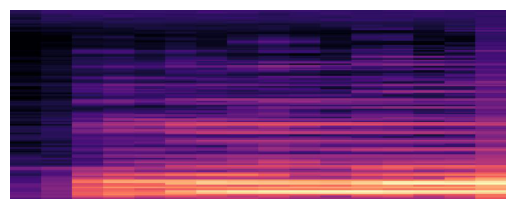

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = os.path.join(preprocessed_train_data_dir, 'Am', 'Am_acousticguitar_Mari_1_0.jpg')

img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

## Track splitting


In [4]:
songs_dir = "songs"
separated_songs_dir = os.path.join(songs_dir, "separated")
song_file_name = "Have-You-Ever-Seen-The-Rain"
song_path = os.path.join(songs_dir, song_file_name + ".mp3")

Extracting the guitar track from the uploaded song. Let's check this feature on the Have You Ever Seen The Rain by Creedence Clearwater Revival which has a distinctive guitar track.


In [10]:
from IPython.display import Audio

Audio(song_path)


Spleeter will divide the song into 4 separate tracks: bass, drums, vocals and other. The guitar will be contained in "other".

In [7]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [8]:
import subprocess

command = f"spleeter separate -p spleeter:4stems -o {separated_songs_dir} {song_path}"
print(command)
subprocess.run(command, shell=True)

spleeter separate -p spleeter:4stems -o songs/separated songs/Have-You-Ever-Seen-The-Rain.mp3


Traceback (most recent call last):
  File "/Users/admin/miniconda3/envs/chordenv/bin/spleeter", line 8, in <module>
    sys.exit(entrypoint())
  File "/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/spleeter/__main__.py", line 267, in entrypoint
    spleeter()
  File "/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/typer/main.py", line 214, in __call__
    return get_command(self)(*args, **kwargs)
  File "/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/click/core.py", line 1066, i

CompletedProcess(args='spleeter separate -p spleeter:4stems -o songs/separated songs/Have-You-Ever-Seen-The-Rain.mp3', returncode=1)

In [14]:
guitar_track_path = os.path.join(separated_songs_dir, song_file_name, "other.wav")

Audio(guitar_track_path)


## Generating spectrograms from the extracted track


In [15]:
output_dir = Path(os.path.join("data", "extracted", song_file_name))

The following function will process each segment of a track and convert it to a spectrogram. The spectrogram will be returned to be used as input to CNN and also will be saved to disk so that if we want to process the same track again, we could use existing data.

The following function detects beat length and generates a spectrogram for each beat. Currently, it returns an array of spectrograms. Later on, predictions of a chord with CNN will be plugged in and it will return a list of predictions.

In [16]:
import librosa

def process_track(audio_path, output_dir):
    y, sr = librosa.load(audio_path, sr=None)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    print(f"Track tempo is {tempo}")
    beat_duration = 60.0 / tempo  # Duration of a beat in seconds

    print(f"Beat duration is {beat_duration} seconds")

    # Calculate the number of samples per beat
    samples_per_beat = int(beat_duration * sr)

    print(f"Samples per beat: {samples_per_beat}")

    spectrograms = []
    for i in range(0, len(y), samples_per_beat):
        end_frame = i + samples_per_beat
        if end_frame > len(y):
            end_frame = len(y)  # Adjust the end frame for the last segment

        segment = y[i:end_frame]
        filename = f'spectrogram_{i // samples_per_beat}.jpg'
        print(f"Create spectrogram {filename}")
        spectrogram = create_spectrogram(segment, sr, os.path.join(output_dir, filename))
        spectrograms.append(spectrogram)

    return spectrograms


If we have spectrograms already stored on the disk, we will use the following function to read them to provide as input to the CNN.

In [11]:
from PIL import Image
import numpy as np
import os

def load_spectrograms(output_dir):
    spectrograms = []
    for filename in os.listdir(output_dir):
        if filename.endswith('.jpg'):  # Ensure to load only jpg files
            file_path = os.path.join(output_dir, filename)
            with Image.open(file_path) as img:
                spectrogram = np.array(img)
                spectrograms.append(spectrogram)
    return spectrograms

To keep things simple, we will consider that the track already processed if the directory with the song name already exists. We can implement more sophisticated and robust checks like file hash sum later.

In [20]:
try:
    if os.path.exists(output_dir):
        print("The track is already processed, load from disk", output_dir)
        spectrograms = load_spectrograms(output_dir)
    else:
        os.makedirs(output_dir)
        print("Processing track")
        spectrograms = process_track(guitar_track_path, output_dir)

        print(spectrograms[:10])
except Exception as e:
    print(e)
    os.removedirs(output_dir)


Processing track
Track tempo is 117.45383522727273
Beat duration is 0.5108390022675736 seconds
Samples per beat: 22527
Create spectrogram spectrogram_0.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_0.jpg
Create spectrogram spectrogram_1.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_1.jpg
Create spectrogram spectrogram_2.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_2.jpg
Create spectrogram spectrogram_3.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_3.jpg
Create spectrogram spectrogram_4.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_4.jpg
Create spectrogram spectrogram_5.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_5.jpg
Create spectrogram spectrogram_6.jpg
Creating spectrogram data/extracted/Have-You-Ever-Seen-The-Rain/spectrogram_6.jpg
Create spectrogram spectrogram_7.jpg
Creating sp

Let's visualize an example of generated spectrogram

In [ ]:
files = os.listdir(output_dir)
image_path = os.path.join(output_dir, files[100])

print(f"Displaying the image at {image_path}")

img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


## Fine tuning ResNet50


In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


Load the model and enable the last layer for fine tuning

In [59]:
num_classes = 8 # we have 8 chords in our dataset
model = models.resnet50(pretrained=True)

# replacing the last layer for fine tuning
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)


/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load saved model

In [5]:
import torchvision.models as models

num_classes = 8 # we have 8 chords in our dataset
model = models.resnet50(pretrained=True)

# replacing the last layer for fine tuning
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load('pretrained_models/chord_classifier.pth'))


/Users/admin/miniconda3/envs/chordenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Chords categorical mapping

In [35]:
chord_labels = ["Am", "Bb", "Bdim", "C", "Dm", "Em", "F", "G"]
label_to_idx = {
    "Am": 0,
    "Bb": 1,
    "Bdim": 2,
    "C": 3,
    "Dm": 4,
    "Em": 5,
    "F": 6,
    "G": 7,
}

"Define our dataset


In [30]:
# TODO: Move labels mapping out of this class so I could use it later
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None, include_labels=True):
        """
        Args:
            root_dir (string): Directory with all the subdirectories for each label.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.samples = []
        self.label_to_idx = label_to_idx
        self.include_labels = include_labels
        # label_idx = 0

        # Iterate over each subdirectory in root_dir
        for label_dir in os.listdir(root_dir):
            label_dir_full_path = os.path.join(root_dir, label_dir)
            if os.path.isdir(label_dir_full_path):
                # if label_dir not in self.label_to_idx:
                #     self.label_to_idx[label_dir] = label_idx
                #     label_idx += 1

                # Iterate over each file in the subdirectory
                for file in os.listdir(label_dir_full_path):
                    file_full_path = os.path.join(label_dir_full_path, file)
                    if os.path.isfile(file_full_path):
                        # Append the file path and its label to the samples list
                        self.samples.append((file_full_path, self.label_to_idx[label_dir]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_idx = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        # the network expects to get images with 3 channels
        if img.mode != 'RGB':
            raise ValueError(f"Image at {img_path} does not have 3 channels")

        if self.transform:
            img = self.transform(img)

        if self.include_labels:
            return img, label_idx

        return img


TODO: double check implementation

In [7]:
from PIL import Image, ImageOps

def resize_and_pad(spectrogram, target_size=(224, 224)):
    # Calculate the resize ratio and resize the spectrogram
    ratio = min(target_size[0] / spectrogram.width, target_size[1] / spectrogram.height)
    new_size = (int(spectrogram.width * ratio), int(spectrogram.height * ratio))
    spectrogram = spectrogram.resize(new_size, Image.LANCZOS)

    # Calculate padding
    delta_width = target_size[0] - new_size[0]
    delta_height = target_size[1] - new_size[1]
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))

    # Add padding
    return ImageOps.expand(spectrogram, padding)


A function to calculate mean and standard deviation for normalization.


In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std


Transform the data to the input format expected by the network. This step without the normalization as we first need to calculate the mean and standard deviation.


In [9]:
from torchvision import transforms

pre_transform = transforms.Compose([
    transforms.Lambda(resize_and_pad),
    transforms.ToTensor(),
])


The following operation is to calculate mean and std across the training dataset for normalization. The next cell is disabled because this operation takes long time to run. Instead, I will hardcode the values received from it earlier.

In [64]:
%%script false --no-raise-error
#| code: true
#| output: false
#} eval: false

pre_dataset = SpectrogramDataset(root_dir=preprocessed_train_data_dir, transform=pre_transform)

pre_loader = DataLoader(pre_dataset, batch_size=64, shuffle=True, num_workers=0)

mean, std = calculate_mean_std(pre_loader)
print(mean, std)


tensor([0.1923, 0.0816, 0.1362]) tensor([0.3121, 0.1567, 0.1977])


In [10]:
mean = [0.1923, 0.0816, 0.1362]
std = [0.3121, 0.1567, 0.1977]

Now that we have all necessary information, we can fully transform the dataset.

In [11]:
transform = transforms.Compose([
    transforms.Lambda(resize_and_pad),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [12]:
dataset = SpectrogramDataset(root_dir=preprocessed_train_data_dir, transform=transform)

Create validation dataset

In [13]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])


Create an optimizer and a loss function. Cross-entropy loss and Adam optimizer seem to be a good choice for a multiclass classification task.


Try to use GPU if available


In [14]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "mps" if getattr(torch, 'has_mps', False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)


The hyperparameter tuning is an expensive operation so I want to minimize the number of parameters to tune. When it comes to training epochs, I started with training for 10 epochs and got the following results:

Epoch 1/10, Loss: 1.0397331823387417
Epoch 2/10, Loss: 0.5051063296001105
Epoch 3/10, Loss: 0.40433394592873295
Epoch 4/10, Loss: 0.3479078058947884
Epoch 5/10, Loss: 0.30994354119586154
Epoch 6/10, Loss: 0.27865488889243156
Epoch 7/10, Loss: 0.2544508595780968
Epoch 8/10, Loss: 0.255094015190678
Epoch 9/10, Loss: 0.2293852458363708
Epoch 10/10, Loss: 0.2278827782764466

As we can see, after epoch 7, there is no decrease in loss. In the future, I will train the model for 7 epochs.

In [15]:
epochs = 7

In [16]:
criterion = nn.CrossEntropyLoss()

In [117]:
def train_model(config):
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=config["batch_size"], shuffle=False)

    num_epochs = config.get("epochs", epochs)

    for epoch in range(num_epochs):
        print(f"Start epoch {epoch}")
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

        # send data to Ray Tune at each epoch to allow the scheduler to cancel inefficient experiments early
        tune.report(loss=val_loss, accuracy=val_accuracy)

    # save the trained model state
    torch.save(model.state_dict(), 'pretrained_models/chord_classifier.pth')



## Hyperparameter tuning

Here I use a Ray Tune scheduler to be able to cut off inefficient experiments early and improve the efficiency of hyperparameter tuning

In [112]:
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t = epochs,
    grace_period=1,
    reduction_factor=2,
)


In [113]:
from ray import tune

config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64, 128])
}

In [139]:
import ray
ray.shutdown()
ray.init(ignore_reinit_error=True, local_mode=True)

2024-01-29 19:45:32,757	INFO worker.py:1724 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.10.13', ray_version='2.9.1', ray_commit='cfbf98c315cfb2710c56039a3c96477d196de049', protocol_version=None)

In [135]:
preprocessed_train_data_dir

PosixPath('/Users/admin/Projects/Chord Classifier/data/preprocessed/train')

In [ ]:
analysis = tune.run(
    train_model,
    config=config,
    num_samples=20,  # Number of times to sample from the hyperparameter space
    resources_per_trial={"cpu": 6},  # Resources per trial
    scheduler=scheduler,
    resume=True
)

In [ ]:
best_config = analysis.get_best_config(metric="accuracy", mode="max")
print("Best config: ", best_config)

Evaluate on validation set


In [87]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


Validation accuracy received on the validation set is 89.97


### Training the model with optimal hyperparameters


In [ ]:
train_model(best_config)


### Testing the model


In [93]:
test_dataset = SpectrogramDataset(root_dir=preprocessed_test_data_dir, transform=transform, include_labels=False)

In [94]:
# test_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [100]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate metrics
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
# TODO: label indexes to labels
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.9355206420650144
Recall: 0.922433706374062
F1 Score: 0.9251709727649703


Precision: 0.9355206420650144
Recall: 0.922433706374062
F1 Score: 0.9251709727649703

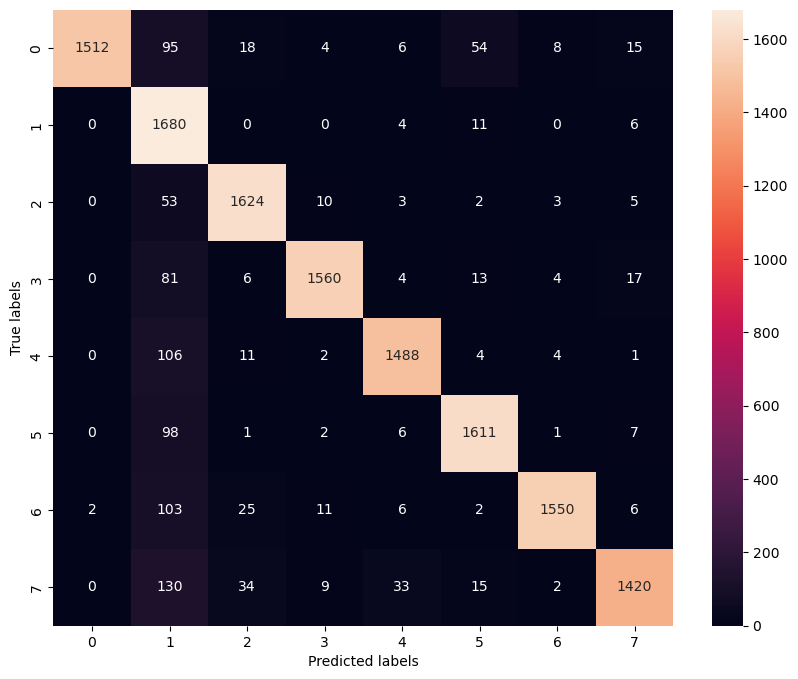

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Inference


In [32]:
from PIL import Image
from torchvision import transforms
import os

def load_spectrogram(file_path):
    image = Image.open(file_path).convert('RGB')  # Convert to RGB if your model expects 3 channels
    return transform(image)


Switch to evaluation mode and convert logits to probabilities using softmax

In [53]:
import torch
import torch.nn.functional as F

# Ensure the model is in evaluation mode
model.eval()

# Define the softmax function
softmax = torch.nn.Softmax(dim=1)

In [63]:
import os

# List all jpg files in the output directory
file_names = [file for file in os.listdir(output_dir) if file.endswith('.jpg')]

# Sort the file names (natural sort or simple alphanumeric sort)
file_names.sort(key=lambda f: int(f.split('_')[-1].split('.')[0]))

In [64]:
spectrograms = [load_spectrogram(os.path.join(output_dir, file)) for file in file_names]


In [65]:
index_to_label = {v: k for k,v in label_to_idx.items()}

print(index_to_label)

N = 3  # Number of top predictions you want

top_labels_all = []
top_confidences_all = []

for spectrogram in spectrograms:
    # Apply the model and get the prediction
    output = model(spectrogram.unsqueeze(0))  # Add batch dimension
    probabilities = softmax(output)

    # Get the top N predictions
    top_probs, top_preds = torch.topk(probabilities, N, dim=1)

    # Convert to labels and confidences
    top_labels = [index_to_label[pred.item()] for pred in top_preds[0]]
    top_confidences = [prob.item() for prob in top_probs[0]]

    top_labels_all.append(top_labels)
    top_confidences_all.append(top_confidences)

{0: 'Am', 1: 'Bb', 2: 'Bdim', 3: 'C', 4: 'Dm', 5: 'Em', 6: 'F', 7: 'G'}


In [66]:
for file, labels, confidences in zip(file_names, top_labels_all, top_confidences_all):
    print(f"{file}:")
    for label, confidence in zip(labels, confidences):
        print(f"  {label}: {confidence:.4f}")

spectrogram_0.jpg:
  Bdim: 0.2824
  G: 0.1877
  F: 0.1787
spectrogram_1.jpg:
  G: 0.9030
  Bdim: 0.0464
  Dm: 0.0349
spectrogram_2.jpg:
  G: 0.9778
  Bdim: 0.0206
  Am: 0.0005
spectrogram_3.jpg:
  G: 0.9601
  Em: 0.0209
  Am: 0.0099
spectrogram_4.jpg:
  Bb: 0.5573
  Bdim: 0.2134
  G: 0.1198
spectrogram_5.jpg:
  Dm: 0.4033
  Bb: 0.3938
  G: 0.0844
spectrogram_6.jpg:
  Bb: 0.2763
  G: 0.2736
  Dm: 0.2354
spectrogram_7.jpg:
  Em: 0.9424
  Bb: 0.0252
  G: 0.0207
spectrogram_8.jpg:
  G: 0.6924
  Em: 0.2716
  Bb: 0.0173
spectrogram_9.jpg:
  Em: 0.9998
  G: 0.0002
  Am: 0.0000
spectrogram_10.jpg:
  Em: 0.6958
  Am: 0.2962
  Bb: 0.0058
spectrogram_11.jpg:
  Am: 0.3013
  G: 0.2349
  Bb: 0.1855
spectrogram_12.jpg:
  Em: 0.9890
  G: 0.0102
  Bb: 0.0005
spectrogram_13.jpg:
  Em: 0.9233
  G: 0.0586
  Bdim: 0.0113
spectrogram_14.jpg:
  Bdim: 0.6132
  G: 0.3129
  C: 0.0442
spectrogram_15.jpg:
  Em: 0.9949
  G: 0.0028
  C: 0.0010
spectrogram_16.jpg:
  G: 0.6083
  Bdim: 0.2725
  Em: 0.1042
spectrogram_

In [34]:
# predictions = [model(s.unsqueeze(0)) for s in spectrograms]

In [51]:
# index_to_label = {v: k for k,v in label_to_idx.items()}
#
# N = 3  # Top N predictions
# softmax = torch.nn.Softmax(dim=1)
#
# # Example: Assuming 'outputs' is the batch output from your model
# outputs = model(inputs)  # 'inputs' should be a batch of data
# probabilities = softmax(outputs)
#
# top_probs, top_preds = torch.topk(probabilities, N, dim=1)
#
# for i in range(top_probs.size(0)):  # Iterate over the batch
#     print(f"Input {i}:")
#     for n in range(N):  # Iterate over top N predictions
#         prob = top_probs[i][n].item()
#         pred_idx = top_preds[i][n].item()
#         label = index_to_label[pred_idx]  # Convert index to label
#         print(f"  {label}: {prob:.4f}")

NameError: name 'inputs' is not defined

In [46]:
# import torch.nn.functional as F
#
# # Assuming 'predictions' contains the raw logits from your model
# softmax_probs = [F.softmax(output, dim=1) for output in predictions]
#
# predicted_labels = []
# confidence_scores = []
#
# for probs in softmax_probs:
#     max_prob, preds = torch.max(probs, dim=1)
#     predicted_labels.append(preds.item())
#     confidence_scores.append(max_prob.item())

In [40]:
# predicted_labels = [chord_labels[torch.argmax(p).item()] for p in predictions]
# print(predicted_labels[0])

Bb


In [47]:
# for file, label, confidence in zip(sorted_files, predicted_labels, confidence_scores):
#     print(f"{file}: {label} with confidence {confidence:.4f}")

spectrogram_0.jpg: 1 with confidence 0.3172
spectrogram_1.jpg: 2 with confidence 0.3603
spectrogram_2.jpg: 7 with confidence 0.3540
spectrogram_3.jpg: 5 with confidence 0.5027
spectrogram_4.jpg: 7 with confidence 0.4281
spectrogram_5.jpg: 7 with confidence 0.4720
spectrogram_6.jpg: 2 with confidence 0.4444
spectrogram_7.jpg: 7 with confidence 0.4826
spectrogram_8.jpg: 1 with confidence 0.4968
spectrogram_9.jpg: 7 with confidence 0.4415
spectrogram_10.jpg: 7 with confidence 0.3176
spectrogram_11.jpg: 2 with confidence 0.6126
spectrogram_12.jpg: 5 with confidence 0.3730
spectrogram_13.jpg: 5 with confidence 0.3690
spectrogram_14.jpg: 5 with confidence 0.7297
spectrogram_15.jpg: 7 with confidence 0.3540
spectrogram_16.jpg: 7 with confidence 0.3766
spectrogram_17.jpg: 2 with confidence 0.3895
spectrogram_18.jpg: 1 with confidence 0.3515
spectrogram_19.jpg: 5 with confidence 0.3286
spectrogram_20.jpg: 7 with confidence 0.3941
spectrogram_21.jpg: 7 with confidence 0.3440
spectrogram_22.jpg: 

In [43]:
# def sort_key(filename):
#     # Split the filename at '_', take the last part, remove the extension, and convert to integer
#     return int(filename.split('_')[-1].split('.')[0])

In [45]:
# sorted_files = sorted(os.listdir(output_dir), key=sort_key)
# for file, chord in zip(sorted_files, predicted_labels):
#     print(f"{file}: {chord}")


spectrogram_0.jpg: Bb
spectrogram_1.jpg: Bdim
spectrogram_2.jpg: G
spectrogram_3.jpg: Em
spectrogram_4.jpg: G
spectrogram_5.jpg: G
spectrogram_6.jpg: Bdim
spectrogram_7.jpg: G
spectrogram_8.jpg: Bb
spectrogram_9.jpg: G
spectrogram_10.jpg: G
spectrogram_11.jpg: Bdim
spectrogram_12.jpg: Em
spectrogram_13.jpg: Em
spectrogram_14.jpg: Em
spectrogram_15.jpg: G
spectrogram_16.jpg: G
spectrogram_17.jpg: Bdim
spectrogram_18.jpg: Bb
spectrogram_19.jpg: Em
spectrogram_20.jpg: G
spectrogram_21.jpg: G
spectrogram_22.jpg: G
spectrogram_23.jpg: G
spectrogram_24.jpg: G
spectrogram_25.jpg: G
spectrogram_26.jpg: Em
spectrogram_27.jpg: G
spectrogram_28.jpg: Bb
spectrogram_29.jpg: Bb
spectrogram_30.jpg: G
spectrogram_31.jpg: G
spectrogram_32.jpg: G
spectrogram_33.jpg: Em
spectrogram_34.jpg: Bdim
spectrogram_35.jpg: Em
spectrogram_36.jpg: G
spectrogram_37.jpg: Em
spectrogram_38.jpg: G
spectrogram_39.jpg: Bb
spectrogram_40.jpg: G
spectrogram_41.jpg: G
spectrogram_42.jpg: G
spectrogram_43.jpg: G
spectrogram_

## Output


* Get top k predictions for each beat
* Discard low confidence predictions
* For each measure select chord that is in all predictions (majority vote). If there multiple chords that are in all predictions, choose with the highest confidence. Drawbacks: need to know the time measure; expect one chord per measure
